In [1]:
# filter(x -> occursin("SLURM", x), keys(ENV))
#ENV["SLURM_NNODES"]
#parse(Int, ENV["SLURM_JOB_CPUS_PER_NODE"])
pwd()

"/Users/julianschmitt/Documents/Research/loss/ClimaAtmos.jl/calibration/experiments/local_calibration"

In [4]:
# activate environment
using Pkg; Pkg.activate(".")

import ClimaAtmos as CA
import ClimaAnalysis: SimDir, get, slice, average_xy
using CairoMakie
import JLD2
import LinearAlgebra: I
import EnsembleKalmanProcesses as EKP
import Statistics: var, mean
using Test
using Revise
using LinearAlgebra: Diagonal
using ClimaCalibrate

# include("observation_map.jl")

# using Revise
# import ClimaCalibrate as CAL
# import ClimaAtmos as CA
# experiment_dir = joinpath(pkgdir(CA), "calibration", "experiments", "gcm_driven_scm")
# model_interface =
#     joinpath(pkgdir(CA), "calibration", "model_interface.jl")
# output_dir = joinpath("output", "gcm_driven_scm")
# # include model interface
# includet(model_interface)
# obs_path = joinpath(experiment_dir, "observations.jld2")


  Activating project at `~/Documents/Research/loss/ClimaAtmos.jl/calibration/experiments/local_calibration`


## Calibration Evaluation and Setup

In [3]:
observations = JLD2.load_object(obs_path)
noise = 0.1 * I
n_iterations = 3
ensemble_size = 9
prior = CAL.get_prior(joinpath(experiment_dir, "prior.toml"))
experiment_config = CAL.ExperimentConfig(;
    n_iterations,
    ensemble_size,
    observations,
    noise,
    output_dir,
    prior,
)

InterruptException: InterruptException:

In [11]:
obs_path = joinpath(experiment_dir, "observations.jld2")
observations = JLD2.load_object(obs_path)
observations

1-element Vector{Float64}:
 285.0

In [ ]:
@everywhere begin
    using JLD2
    experiment_dir = dirname(Base.active_project())
    obs_path = joinpath(experiment_dir, "observations.jld2")
    if !isfile(obs_path)
        error("Observation file not found at: $obs_path")
    else
        println("Worker ", myid(), " can access the observations file.")
    end
end

In [ ]:
reshape(G_ens[1,:], 1, 10)
EKP.update_ensemble!(eki, reshape(G_ens[1,:], 1, 10))
CAL.save_eki_state(eki, output_dir, 1, prior)

## Visualization

In [71]:
# imports 
import EnsembleKalmanProcesses as EKP
using EnsembleKalmanProcesses.ParameterDistributions
using EnsembleKalmanProcesses.TOMLInterface
using Distributions
import Statistics: mean
import CairoMakie: Makie
import ClimaCalibrate

In [19]:
function convergence_plot(
    eki::EKP.EnsembleKalmanProcess,
    prior::ParameterDistribution;
    theta_star = 65.0,
    output = joinpath("output", "sphere_held_suarez_rhoe_equilmoist"),
)
    u_vec = EKP.get_u(eki)
    meanabsdiff²(x, e) = sum(i -> abs(i - x)^2, e) / length(e)
    error_vec = map(ensemble -> meanabsdiff²(theta_star, ensemble), u_vec)
    spread_vec = map(ensemble -> meanabsdiff²(mean(ensemble), ensemble), u_vec)
    phi_vec = transform_unconstrained_to_constrained(prior, u_vec)
    u_series = eachcol(reduce(vcat, u_vec))
    phi_series = eachcol(reduce(vcat, phi_vec))

    f = Makie.Figure(title = "Convergence Plot", resolution = (800, 800))

    ax = Makie.Axis(
        f[1, 1],
        xlabel = "Iteration",
        ylabel = "Error",
        xticks = 0:50,
    )
    Makie.lines!(ax, 0.0:(length(error_vec) - 1), error_vec)

    ax = Makie.Axis(
        f[1, 2],
        xlabel = "Iteration",
        ylabel = "Spread",
        xticks = 0:50,
    )
    Makie.lines!(ax, 0.0:(length(spread_vec) - 1), spread_vec)

    ax = Makie.Axis(
        f[2, 1],
        xlabel = "Iteration",
        ylabel = "Unconstrained Parameters",
        xticks = 0:50,
    )
    Makie.lines!.(ax, tuple(0.0:(length(u_series[1]) - 1)), u_series)

    ax = Makie.Axis(
        f[2, 2],
        xlabel = "Iteration",
        ylabel = "Constrained Parameters",
        xticks = 0:50,
    )
    Makie.lines!.(ax, tuple(0.0:(length(phi_series[1]) - 1)), phi_series)
    #Makie.hlines!(ax, [theta_star], color = :red, linestyle = :dash)
    Makie.save(joinpath(output, "convergence.png"), f)
end

function scatter_plot(
    eki,
    output = joinpath("output", "sphere_held_suarez_rhoe_equilmoist"),
)
    # Define figure with explicit size
    f = Makie.Figure(resolution = (800, 600))
    a = Makie.Axis(
        f[1, 1],
        title = "60-Day Zonal Avg Temp at 242m versus Unconstrained Equator-Pole Temp Gradient",
        ylabel = "Parameter Value",
        xlabel = "Temperature (K)",
    )

    g = vec.(EKP.get_g(eki; return_array = true))
    u = vec.(EKP.get_u(eki; return_array = true))

    for (gg, uu) in zip(g, u)
        Makie.scatter!(a, gg, uu)
    end

    # Save the figure
    Makie.save(joinpath(output, "scatter.png"), f)
end

scatter_plot (generic function with 2 methods)

In [73]:
println(pwd())
output_dir = "output/local_calibration"
println(output_dir)
readdir(output_dir)

/Users/julianschmitt/Documents/Research/loss/ClimaAtmos.jl/calibration/experiments/local_calibration
output/local_calibration


6-element Vector{String}:
 ".DS_Store"
 "iteration_000"
 "iteration_001"
 "iteration_002"
 "iteration_003"
 "iteration_004"

In [80]:
import JLD2
iteration = 5
output_dir = joinpath("output", "local_calibration")
eki_filepath = joinpath(ClimaCalibrate.path_to_iteration(output_dir, iteration), "eki_file.jld2")
eki = JLD2.load_object(eki_filepath)
prior_path = joinpath("prior.toml")
prior = ClimaCalibrate.get_prior(prior_path)


ParameterDistribution with 5 entries: 
'mixing_length_eddy_viscosity_coefficient' with Constraint{BoundedBelow}[Bounds: (0.0, ∞)] over distribution Parameterized(Normal{Float64}(μ=-1.798899386179365, σ=0.23213161890397324)) 
'detr_massflux_vertdiv_coeff' with Constraint{BoundedBelow}[Bounds: (0.0, ∞)] over distribution Parameterized(Normal{Float64}(μ=0.13599544622138604, σ=0.0867928125339026)) 
'entr_coeff' with Constraint{BoundedBelow}[Bounds: (0.0, ∞)] over distribution Parameterized(Normal{Float64}(μ=-1.130668870398269, σ=0.20979154356960092)) 
'entr_inv_tau' with Constraint{BoundedBelow}[Bounds: (0.0, ∞)] over distribution Parameterized(Normal{Float64}(μ=-6.554970428702886, σ=0.3245928459745013)) 
'mixing_length_diss_coeff' with Constraint{BoundedBelow}[Bounds: (0.0, ∞)] over distribution Parameterized(Normal{Float64}(μ=-1.484574651461414, σ=0.17261912641693183)) 


In [81]:
eki.Δt

5-element Vector{Float64}:
 9.967957629437544e-5
 0.00011033047752605121
 4.409261544563538e-5
 4.769808431584255e-5
 0.0015677208061046753

In [82]:
size(vcat(EKP.transform_unconstrained_to_constrained(prior, EKP.get_u(eki))...), 2)

3

In [83]:
names = EKP.get_name(prior)

# get parameter data and put in matrix form 
params = EKP.transform_unconstrained_to_constrained(prior, EKP.get_u(eki))
params = EKP.transform_unconstrained_to_constrained(prior, EKP.get_u(eki))
params = vcat(params...)
params = reshape(params, length(names), eki.N_ens, iteration+1)
params = permutedims(params, (3, 1, 2));

In [84]:
params

6×5×3 Array{Float64, 3}:
[:, :, 1] =
 0.20239   1.05932   0.360996  0.00120319   0.231664
 0.226713  0.758913  0.298667  0.000868695  0.453326
 0.134227  1.23494   0.304929  0.00118631   0.312001
 0.14902   0.890881  0.252088  0.000859736  0.608817
 0.147536  1.38815   0.358695  0.00141414   0.196427
 0.159764  1.01926   0.295513  0.00103371   0.381926

[:, :, 2] =
 0.161397  1.08998   0.314317  0.00112049   0.315565
 0.182719  0.772893  0.259846  0.000803511  0.62289
 0.107069  1.27077   0.265568  0.00110501   0.424717
 0.12351   0.905801  0.223449  0.000803968  0.801268
 0.117482  1.42879   0.312072  0.00131656   0.267997
 0.128583  1.03832   0.256903  0.000955829  0.525651

[:, :, 3] =
 0.176456  0.928998  0.294253  0.000973948  0.410403
 0.23906   0.627896  0.265984  0.000718125  0.676881
 0.116993  1.08581   0.249023  0.000962977  0.549305
 0.1608    0.736972  0.228202  0.000718133  0.87461
 0.128143  1.22302   0.292684  0.00114873   0.346048
 0.167168  0.84323   0.26171   0.00085

In [85]:
mean(params[:, 3, :], dims = 2)

6×1 Matrix{Float64}:
 0.32318857870823897
 0.27483252740587955
 0.2731731011285626
 0.2345797899540507
 0.32115032414278993
 0.27137573545946686

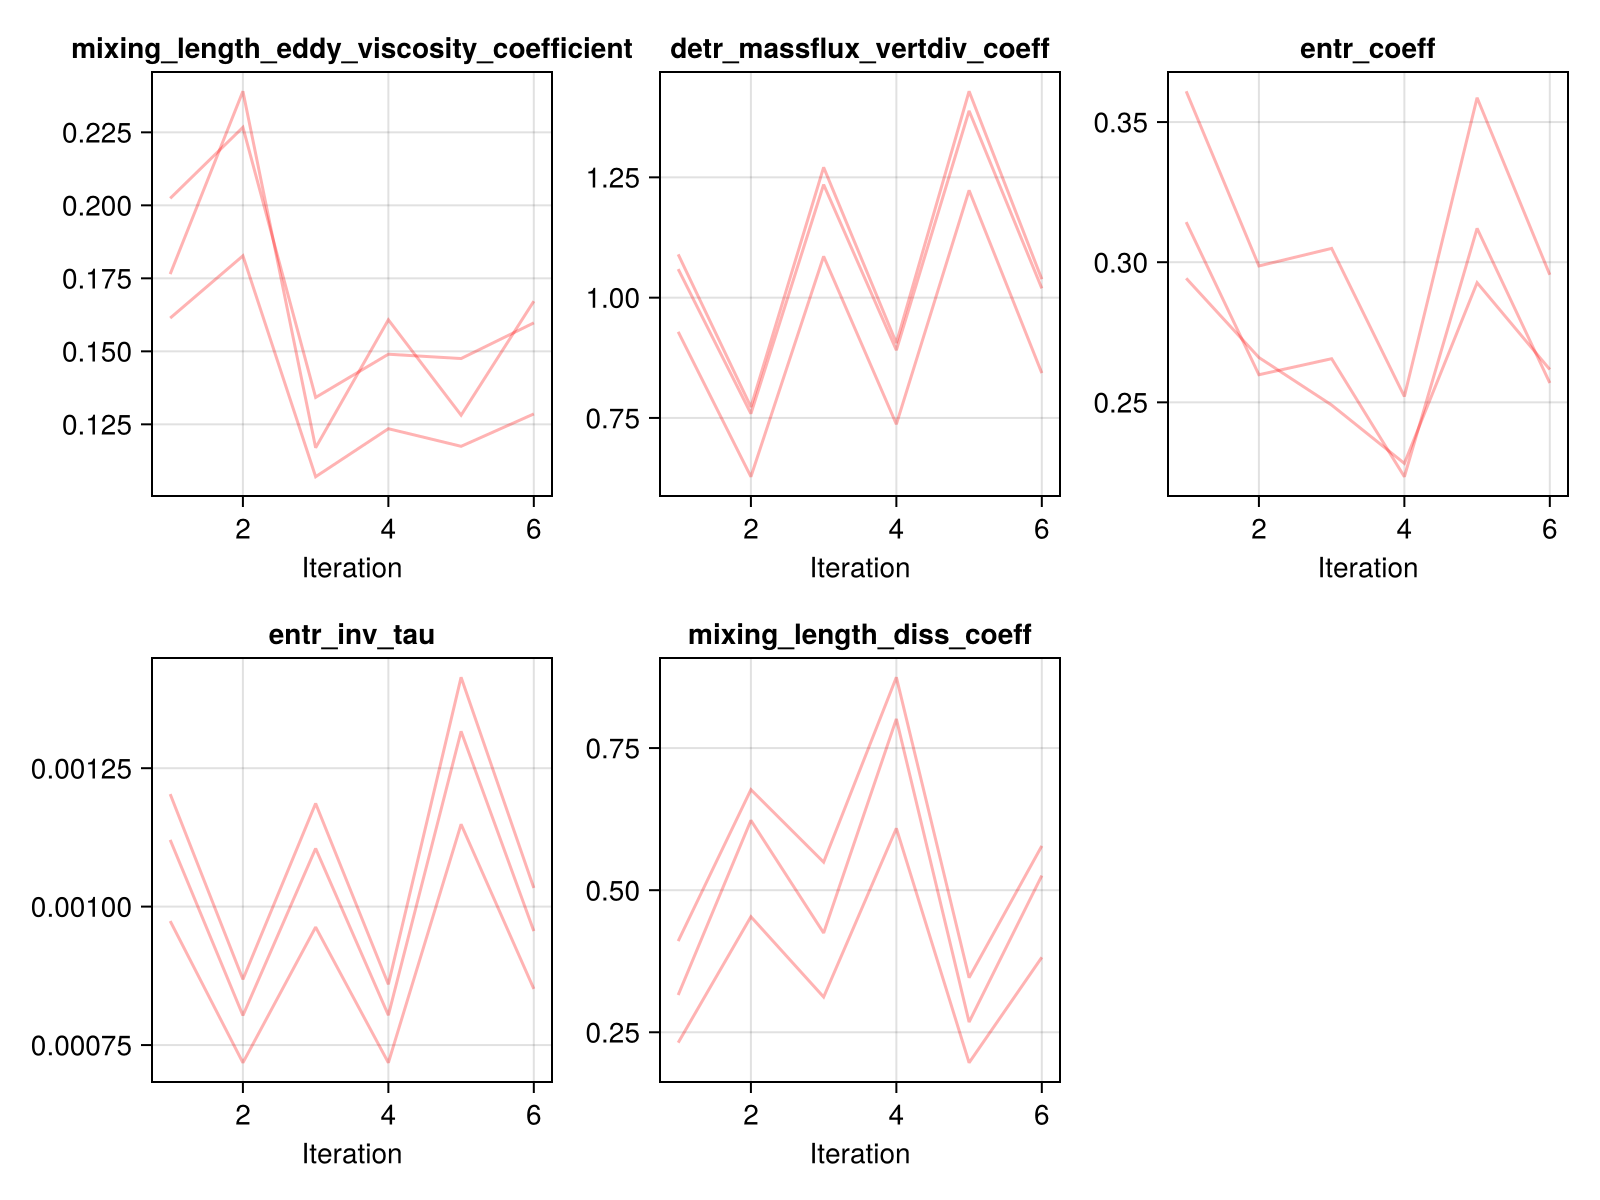

In [86]:
fig = Figure(size = (800, 600))

num_per_row = 3
for i in 1:length(names)
    row = div(i-1, num_per_row) + 1
    col = mod(i-1, num_per_row) + 1
    
    ax = Axis(fig[row, col], title = names[i], xlabel = "Iteration")
    
    for j in 1:size(params, 3)
        lines!(ax, 1:size(params, 1), params[:, i, j], color = :red, alpha = 0.3)
    end
end
fig

In [15]:
# create a similar plot but show the loss function value (e.g., rlut) instead of the parameter value
fieldnames(EKP.EnsembleKalmanProcess)

(:u, :observation_series, :N_ens, :g, :err, :scheduler, :accelerator, :Δt, :process, :rng, :failure_handler, :localizer, :verbose)

In [80]:
mean(loss_vals[1,:][(!).(isnan.(loss_vals[1, :]))])

276.5868225097656

In [87]:
function mean_ignore_nan(arr, dim)
    mean_values = mapslices(x -> mean(x[(!).(isnan.(x))]), arr, dims=dim)
    return vec(mean_values)
end

mean_ignore_nan(loss_vals, 2)

5-element Vector{Float64}:
 276.5868225097656
 276.3648173014323
 275.94365844726565
 275.67548217773435
 275.2759053548177

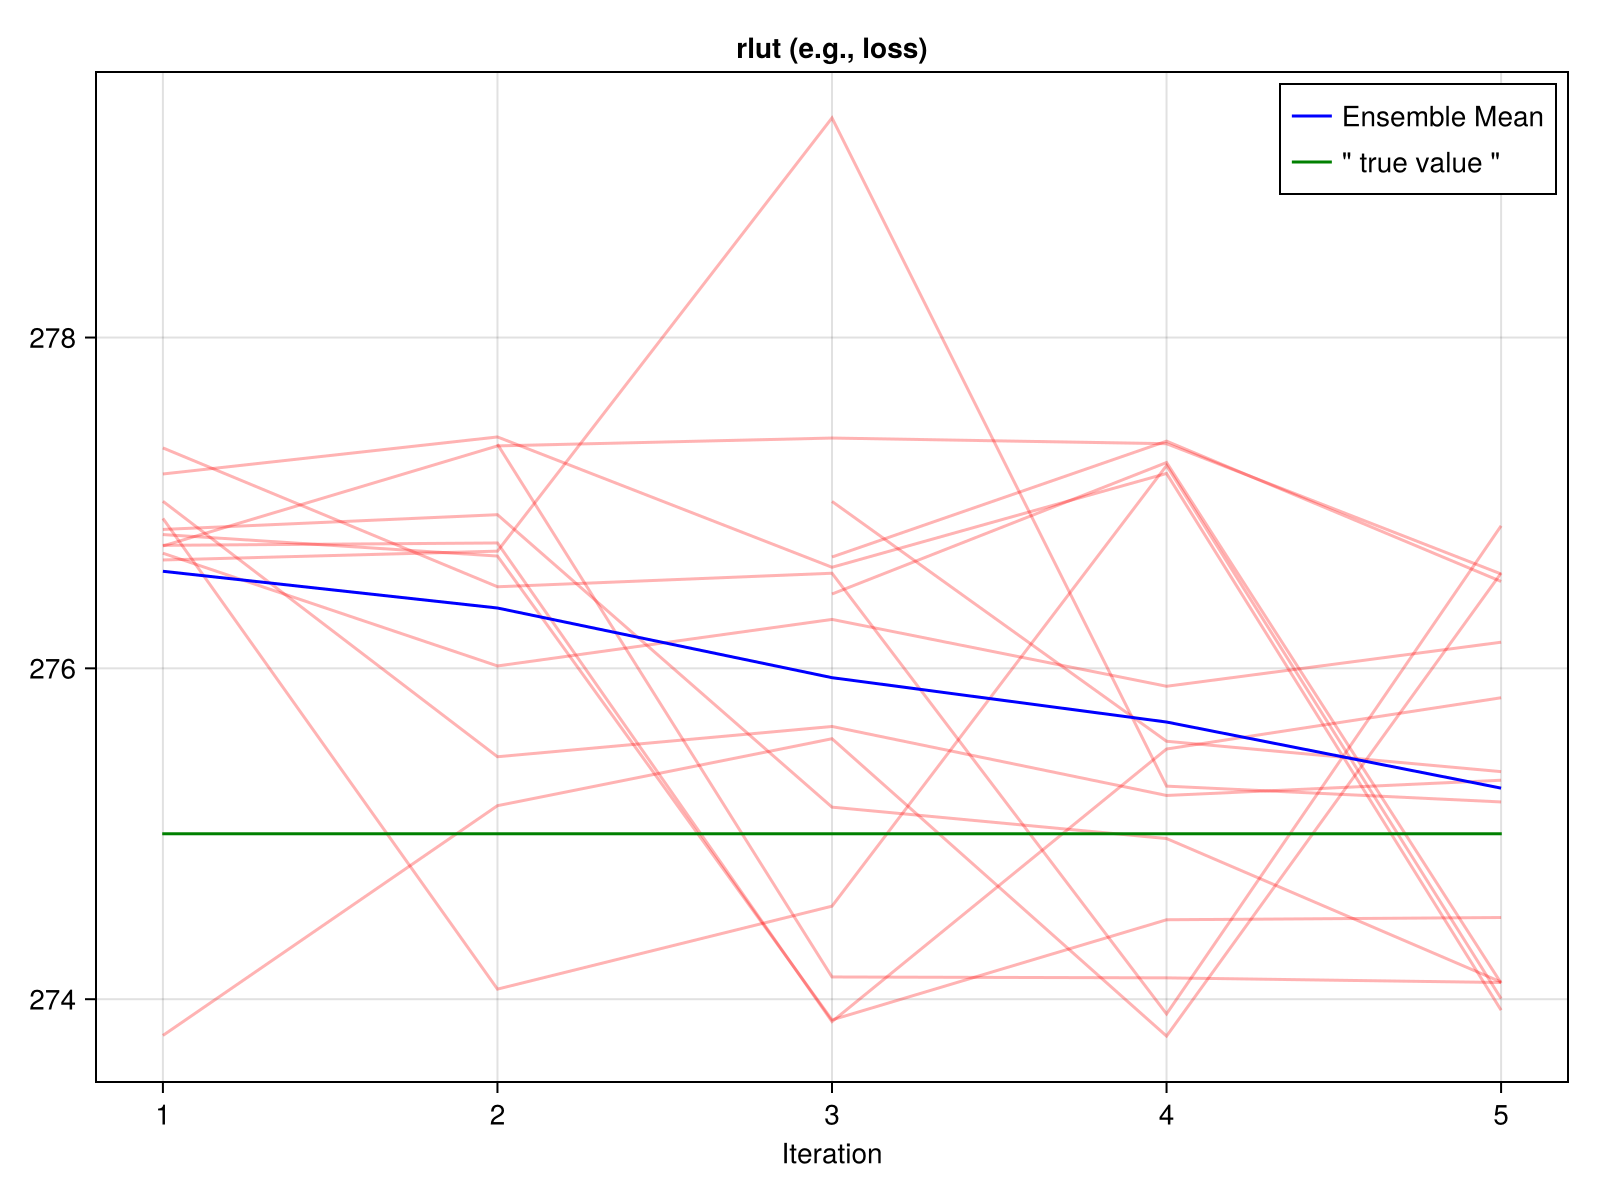

In [107]:
loss_vals = vcat(EKP.get_g(eki)...)

fig = Figure(size = (800, 600))
ax = Axis(fig[1, 1], title = "rlut (e.g., loss)", xlabel = "Iteration")
for i in 1:size(loss_vals, 2)
    lines!(ax, 1:size(loss_vals, 1), loss_vals[:, i], color = :red, alpha = 0.3)
end
lines!(ax, 1:size(loss_vals, 1), mean_ignore_nan(loss_vals, 2), color = :blue, label = "Ensemble Mean")
hlines!(ax, [275], xmin = .045, xmax= .955, color = :green, label = "\" true value \"")
# legend = Legend(fig, ax, tellwidth = false, tellheight = false)
# fig[1, 2] = legend
axislegend(ax, position = :rt)
fig
# size(loss_vals, 1)
# loss_vals[1][:]

# reshape loss_vals to be matrix 
# size(loss_vals)

In [145]:
# generate some plots of all variables for different simulations
# argmin(abs.(loss_vals .- 275))
best = argmin(replace(abs.(loss_vals .-275), NaN => Inf))
worst = argmax(replace(abs.(loss_vals .-275), NaN => -Inf))

println("Best: ", best, loss_vals[best])
println("Worst: ", worst, loss_vals[worst])


Best: CartesianIndex(4, 3)274.9712219238281
Worst: CartesianIndex(3, 6)279.3276062011719


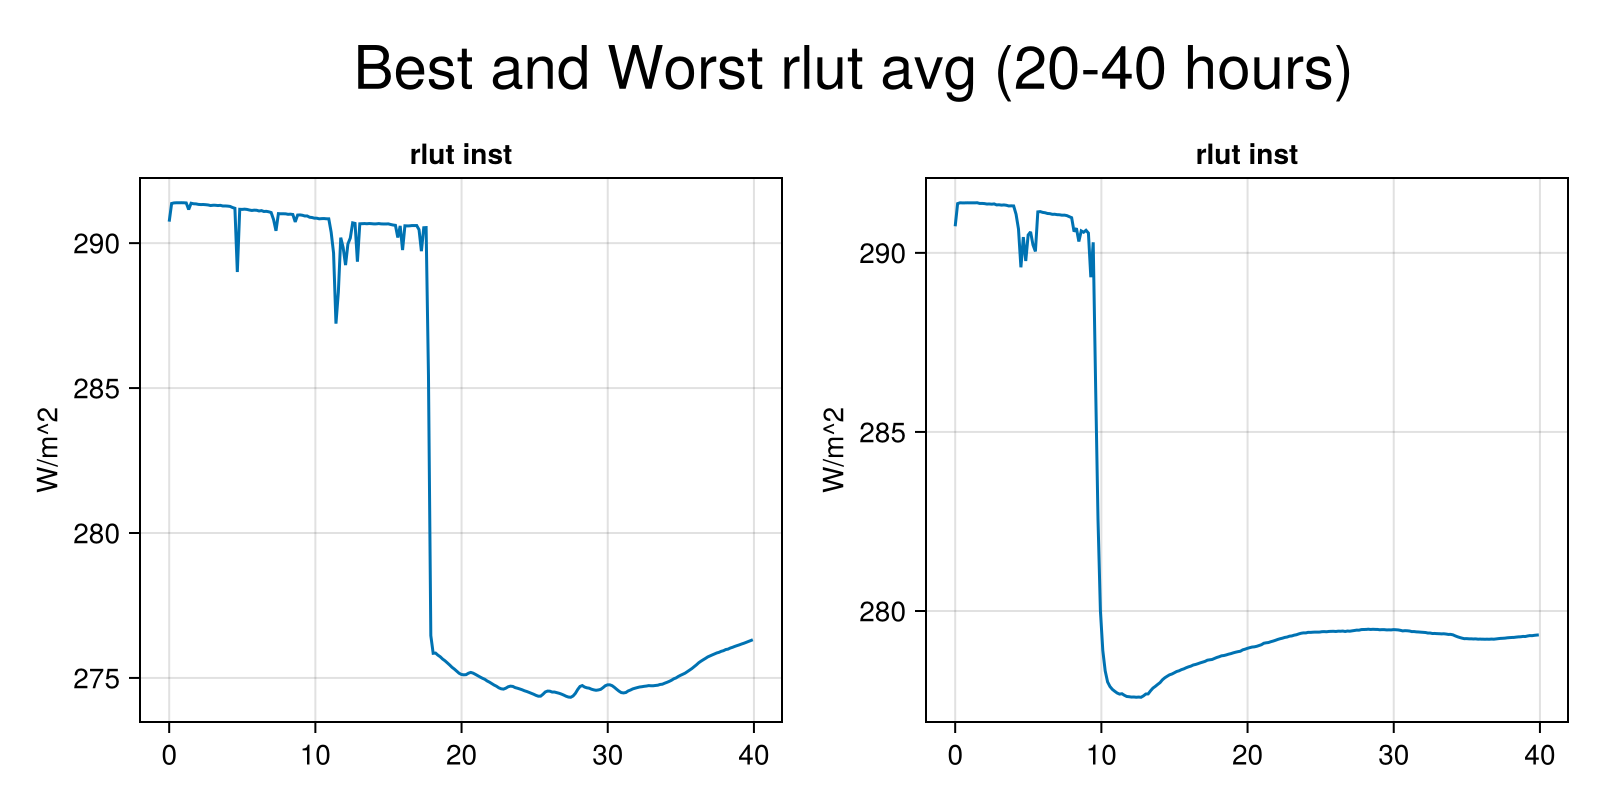

In [149]:
fig = Figure(size = (800, 400))
min_simdir = SimDir(joinpath("output", "gcm_driven_scm", "iteration_003", "member_003","output_active"))
max_simdir = SimDir(joinpath("output", "gcm_driven_scm", "iteration_002", "member_006","output_active"))

add_var(fig, "rlut", min_simdir, 1, 1, lines = true)
add_var(fig, "rlut", max_simdir, 1, 2, lines = true)
supertitle = Label(fig[0, :], "Best and Worst rlut avg (20-40 hours)", fontsize = 30)

fig

In [3]:
#simdir = SimDir(joinpath("output", "gcm_driven_scm", "iteration_004", "member_001","output_active"))
# println(summary(simdir))

function add_var(fig, var, simdir = simdir, col = 1, ind = 1; lines = false, reduction = "inst")
    # get data 
    da = get(simdir; short_name = var, reduction = "inst")
    title = "$var $reduction"
    if lines
        ax = Axis(fig[col, ind], ylabel = "W/m^2", title = title)
        ln = lines!(da.dims["time"]/ 21600*6, da.data[:, 1, 1])
       # Colorbar(fig[col, ind+1], ln, label = var)
    elseif var == "wa"
        ax = Axis(fig[col, ind][1, 1], ylabel = "height (km)", xlabel="time (hrs)", title = title)
        hm = heatmap!(da.dims["time"][1:end]/ 21600*6, 
                      da.dims["z"][1:20]/1000,
                      da.data[1:end, 1, 1, 1:20])
        Colorbar(fig[col, ind][1,2], hm)
    else
        ax = Axis(fig[col, ind][1, 1], ylabel = "height (km)", xlabel="time (hrs)", title = title)
        hm = heatmap!(da.dims["time"]/ 21600*6, 
                      da.dims["z"][1:20]/1000,
                      da.data[:, 1, 1, 1:20])
        Colorbar(fig[col, ind][1,2], hm)
    end
end

function plot_defaults(dirname)
    simdir = SimDir(dirname)

    fig = Figure(size=(1400,800))

    vars = ["clw", "wa", "entr", "hus", "rlut", "rlutcs", "rsut", "rsutcs", "waup", "tke"]
    for (ind, var) in enumerate(["ta", "wa", "clw", "cl", "rlut", "rlutcs", "rsut", "rsutcs", "waup", "tke", "arup", "entr", "detr"])
        if var in ["rlut", "rlutcs", "rsut", "rsutcs"] # add lines
            add_var(fig, var, simdir, ind % 4 + 1, div(ind, 4) + 1, lines = true)
        else
            add_var(fig, var, simdir, ind % 4 + 1, div(ind, 4) + 1)
        end
    end
    add_var(fig, "tke", simdir, 1, 1, lines = false, reduction = "max")

    fig 
end

plot_defaults(joinpath("output", "gcm_driven_scm", "iteration_003", "member_003","output_active"))

plot_defaults (generic function with 1 method)

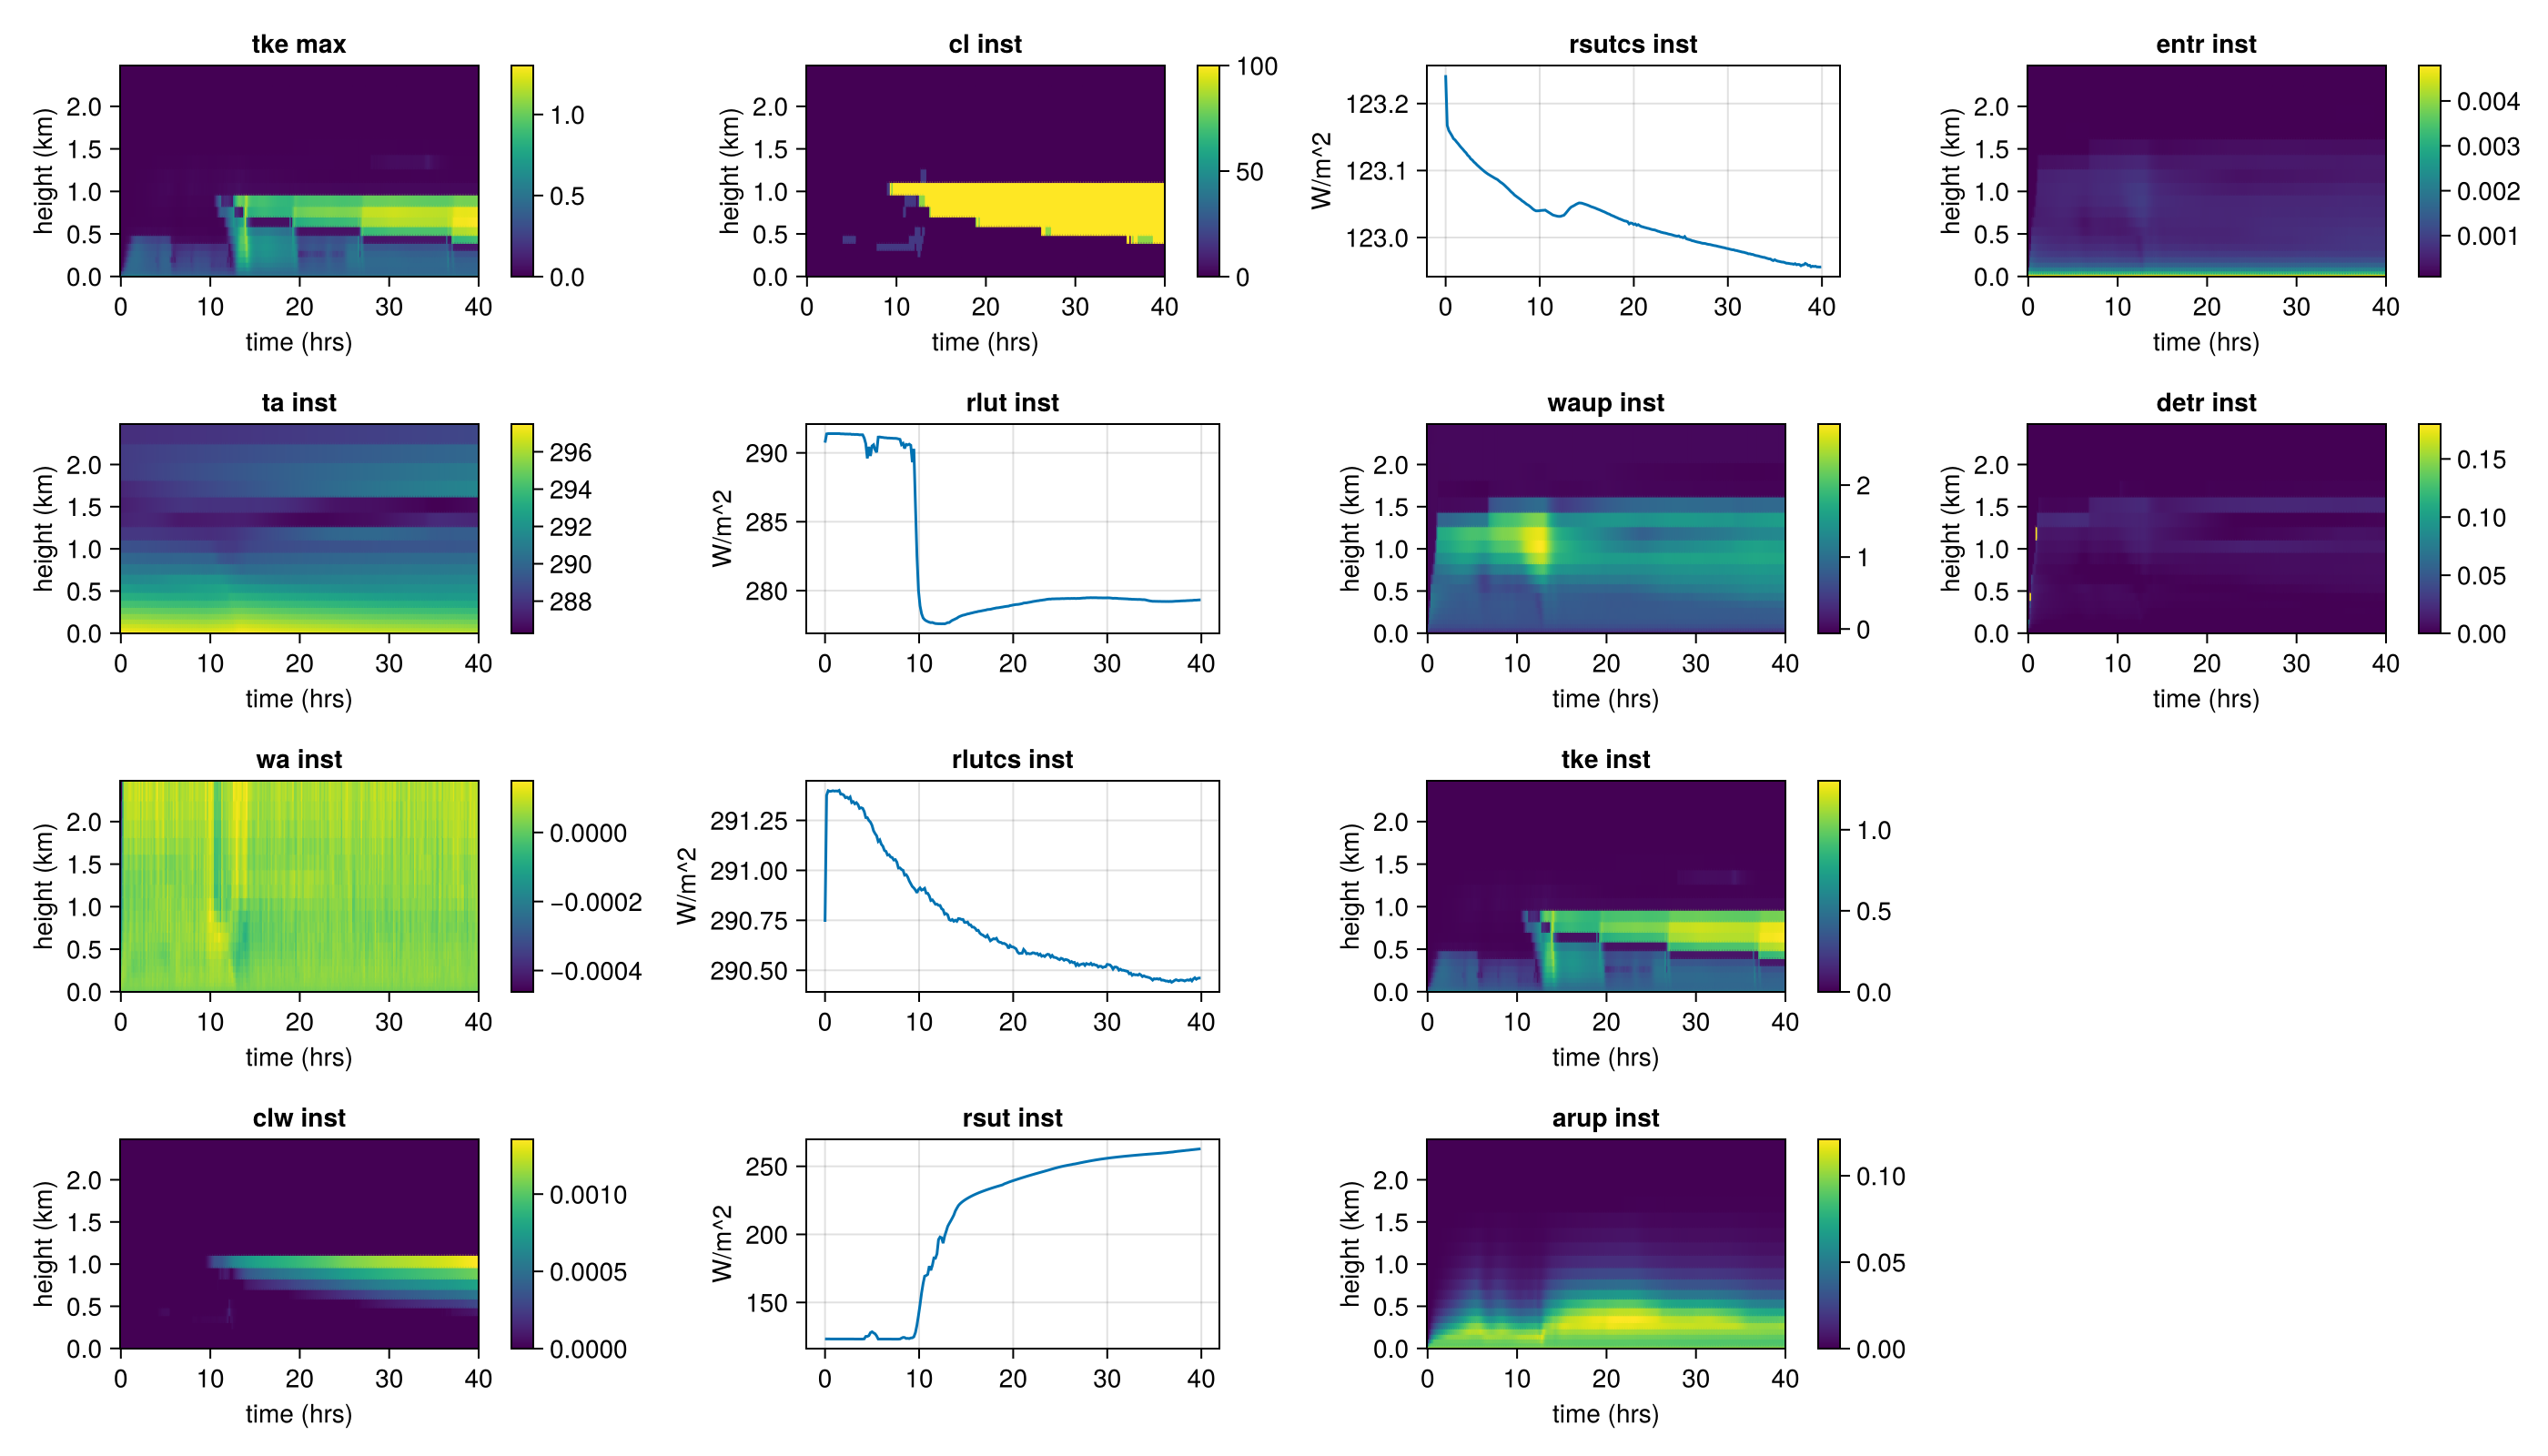

In [151]:
plot_defaults(joinpath("output", "gcm_driven_scm", "iteration_002", "member_006","output_active"))

## Dev function to generate profiles

In [5]:
import YAML
import ClimaAnalysis: SimDir, get, slice, average_xy, available_vars, window, average_time

In [19]:
pwd()
simpath = joinpath("output", "local_calibration", "output_active")
simdir = SimDir(simpath)
variables = collect(available_vars(simdir))

46-element Vector{Any}:
 "rhoa"
 "taen"
 "pr"
 "waup"
 "wa"
 "ua"
 "cli"
 "thetaaup"
 "hussfc"
 "tke"
 ⋮
 "huren"
 "clw"
 "va"
 "husen"
 "pfull"
 "rlutcs"
 "clien"
 "hurup"
 "waen"

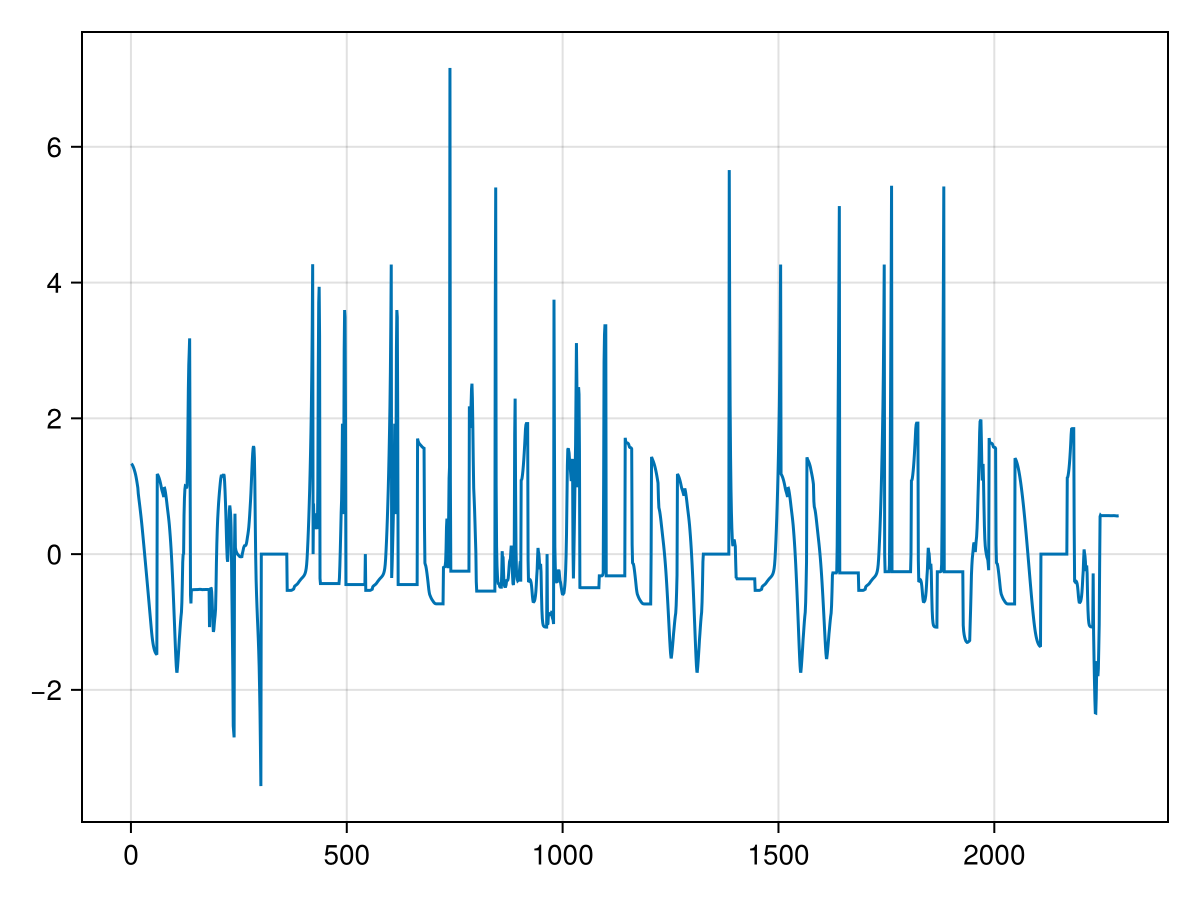

In [25]:
fieldnames(typeof(simdir))
# read in experiment config 
experiment_config = YAML.load_file("experiment_config.yml")

# # compute the window time average
# da_var = get(simdir; short_name = "ta", reduction = "inst")
# da_slice = window(da_var, "time", left = experiment_config["g_t_start_sec"], right = experiment_config["g_t_end_sec"])
# da_slice = average_time(da_slice)
# da_slice.data[1, 1, :]


function extract_profile(simdir, var, experiment_config)
    da_var = get(simdir; short_name = var, reduction = "inst")
    da_slice = window(da_var, "time", left = experiment_config["g_t_start_sec"], right = experiment_config["g_t_end_sec"])
    da_slice = average_time(da_slice)
    return da_slice.data[1, 1, :]
end

# function to extract all profiles from a simulation directory
function extract_profiles(simdir, experiment_config)
    profiles = Dict()
    for variable in available_vars(simdir)
        profile = extract_profile(simdir, variable, experiment_config)
        profiles[variable] = Dict("profile" => profile, "μ" => mean(profile), "σ²" => var(profile))
    end
    return profiles
end

profiles = extract_profiles(simdir, experiment_config)

# combine profiles into a single vector, normalizing by mean and variance 
function combine_profiles(profiles)
    profile_vec = []
    for variable in available_vars(simdir)
        profile = profiles[variable]["profile"]
        μ = profiles[variable]["μ"]
        σ² = profiles[variable]["σ²"]
        profile = σ² > 0 ? (profile .- μ) ./ sqrt(σ²) : profile .- μ
        append!(profile_vec, profile)
    end
    return profile_vec
end
combined = combine_profiles(profiles)
lines(combined)

In [23]:
tapio_loss_vars = ["ta", "thetaa", "ha", "rhoa", 
                    "hur", "hus", "cl", "clw",
                     "hussfc", 
                     "rlut", "rlutcs", "rsut", "rsutcs"]
# extract all profiles for all simulations with fixed relative error
function combine_profiles(simdir, experiment_config; vars = tapio_loss_vars)
    profiles = extract_profiles(simdir, experiment_config, vars = vars)
    profile_vec = Float64[]
    var_vec = Float64[]
    for variable in vars
        profile = profiles[variable]["profile"]
        μ = profiles[variable]["μ"]
        σ² = profiles[variable]["σ²"]

        #profile = σ² > 0 ? (profile .- μ) ./ sqrt(σ²) : profile .- μ
        if variable in ["rlut", "rlutcs", "rsut", "rsutcs"]
            append!(profile_vec, profile) 
            append!(var_vec, 1) # typical error of 1 W/m^2 for radiative variables
        elseif variable in ["hussfc"]
            append!(profile_vec, profile)
            append!(var_vec, 1e-4) 
        else
            append!(profile_vec, profile)
            append!(var_vec, repeat([σ²], length(profile))) # 1% relative error
        end
    end
    return profile_vec, var_vec
end

function extract_profiles(simdir, experiment_config; vars = tapio_loss_vars)
    profiles = Dict()
    for variable in vars
        profile = extract_profile(simdir, variable, experiment_config)
        # add artificial noise to the profile
        profile = profile .* (1 .+ randn(length(profile)) ./ 100)
        profiles[variable] = Dict("profile" => profile, "μ" => mean(profile), "σ²" => var(profile))
    end
    return profiles
end


#cat_profile, noise = combine_profiles(simdir, experiment_config, vars = tapio_loss_vars)

extract_profiles (generic function with 1 method)

In [34]:
experiment_config = YAML.load_file("experiment_config.yml")

function extract_profiles_int(simdir, experiment_config; vars = tapio_loss_vars)
    profiles = Dict()
    for variable in vars
        profile = extract_profile(simdir, variable, experiment_config)
        # take vertical mean
        profile = mean(profile)
        # add 1% artificial noise to the profile
        profile = profile .* (1 .+ randn(length(profile)) ./ 100)
        profiles[variable] = Dict("profile" => profile, "σ²" => profile/100)
    end
    return profiles
end
extract_profiles_int(simdir, experiment_config, vars = ["thetaa", "hur", "hus", "cl", "clw", "rlut", "rlutcs", "rsut", "rsutcs"])

Dict{Any, Any} with 9 entries:
  "cl"     => Dict("profile"=>[8.79035], "σ²"=>[0.0879035])
  "rsutcs" => Dict("profile"=>[122.051], "σ²"=>[1.22051])
  "clw"    => Dict("profile"=>[7.11491e-5], "σ²"=>[7.11491e-7])
  "rlutcs" => Dict("profile"=>[288.558], "σ²"=>[2.88558])
  "hus"    => Dict("profile"=>[0.00409013], "σ²"=>[4.09013e-5])
  "rlut"   => Dict("profile"=>[276.452], "σ²"=>[2.76452])
  "hur"    => Dict("profile"=>[0.356839], "σ²"=>[0.00356839])
  "thetaa" => Dict("profile"=>[401.698], "σ²"=>[4.01698])
  "rsut"   => Dict("profile"=>[278.46], "σ²"=>[2.7846])

In [35]:
get(simdir; short_name = "rsutcs", reduction = "inst").data

249×2×2 Array{Float32, 3}:
[:, :, 1] =
 123.242  123.242
 123.167  123.167
 123.16   123.16
 123.156  123.156
 123.152  123.152
 123.15   123.15
 123.147  123.147
 123.144  123.144
 123.142  123.142
 123.139  123.139
   ⋮      
 123.034  123.034
 123.034  123.034
 123.033  123.033
 123.033  123.033
 123.033  123.033
 123.033  123.033
 123.032  123.032
 123.032  123.032
 123.031  123.031

[:, :, 2] =
 123.242  123.242
 123.167  123.167
 123.16   123.16
 123.156  123.156
 123.152  123.152
 123.15   123.15
 123.147  123.147
 123.144  123.144
 123.142  123.142
 123.139  123.139
   ⋮      
 123.034  123.034
 123.034  123.034
 123.033  123.033
 123.033  123.033
 123.033  123.033
 123.033  123.033
 123.032  123.032
 123.032  123.032
 123.031  123.031

In [52]:
function cat_obs(dict)
    obs = Float64[]
    vars = Float64[]
    for (key, value) in dict
        append!(obs, value["profile"])
        append!(vars, value["σ²"])
    end
    return obs, vars
end 
obs, obs_variance = cat_obs(extract_profiles_int(simdir, experiment_config, 
            vars = ["thetaa", "hur", "hus", "cl", "clw", "rlut", "rlutcs", "rsut", "rsutcs"]))
obs, obs_variance

([8.633257615267864, 123.89262582367597, 7.187324041971504e-5, 292.69537820467156, 0.004106470043546203, 282.0426576280664, 0.3602339510686849, 413.138604150189, 274.37836958269037], [0.08633257615267864, 1.2389262582367597, 7.187324041971504e-7, 2.9269537820467155, 4.106470043546203e-5, 2.8204265762806644, 0.0036023395106868487, 4.13138604150189, 2.7437836958269037])

In [54]:
Diagonal(obs_variance)

9×9 Diagonal{Float64, Vector{Float64}}:
 0.0863326   ⋅        ⋅           ⋅       …   ⋅           ⋅        ⋅ 
  ⋅         1.23893   ⋅           ⋅           ⋅           ⋅        ⋅ 
  ⋅          ⋅       7.18732e-7   ⋅           ⋅           ⋅        ⋅ 
  ⋅          ⋅        ⋅          2.92695      ⋅           ⋅        ⋅ 
  ⋅          ⋅        ⋅           ⋅           ⋅           ⋅        ⋅ 
  ⋅          ⋅        ⋅           ⋅       …   ⋅           ⋅        ⋅ 
  ⋅          ⋅        ⋅           ⋅          0.00360234   ⋅        ⋅ 
  ⋅          ⋅        ⋅           ⋅           ⋅          4.13139   ⋅ 
  ⋅          ⋅        ⋅           ⋅           ⋅           ⋅       2.74378

In [55]:
# save 
JLD2.save_object("observations.jld2", obs)
JLD2.save_object("obs_noise_cov.jld2", Diagonal(obs_variance))

In [8]:
simdir = SimDir(joinpath("output", "local_calibration", "iteration_000", "member_001","output_active"))

SimDir{Dict{Any, Any}, Dict{Any, Any}}("output/local_calibration/iteration_000/member_001/output_active", Dict{Any, Any}("rhoa" => Dict{Any, Any}("inst" => Dict{Any, Any}("10m" => "output/local_calibration/iteration_000/member_001/output_active/rhoa_10m_inst.nc")), "taen" => Dict{Any, Any}("inst" => Dict{Any, Any}("10m" => "output/local_calibration/iteration_000/member_001/output_active/taen_10m_inst.nc")), "pr" => Dict{Any, Any}("inst" => Dict{Any, Any}("10m" => "output/local_calibration/iteration_000/member_001/output_active/pr_10m_inst.nc")), "waup" => Dict{Any, Any}("inst" => Dict{Any, Any}("10m" => "output/local_calibration/iteration_000/member_001/output_active/waup_10m_inst.nc")), "wa" => Dict{Any, Any}("inst" => Dict{Any, Any}("10m" => "output/local_calibration/iteration_000/member_001/output_active/wa_10m_inst.nc")), "ua" => Dict{Any, Any}("inst" => Dict{Any, Any}("10m" => "output/local_calibration/iteration_000/member_001/output_active/ua_10m_inst.nc")), "cli" => Dict{Any, An

In [ ]:
[thetaa, hur, hus, cl, clw, cli, rlut, rlutcs, rsut, rsutcs]
# integrals of cl, clw, cli try


In [60]:
function process_member_data(
    simdir;
    y_names,
    reduction = "inst",
    t_start,
    t_end,
    # norm_vec_obs = [0.0, 1.0],
    # normalize = true,
)

    g = Float64[]

    for (i, y_name) in enumerate(y_names)
        var_i = get(simdir; short_name = y_name, reduction = reduction)
        sim_t_end = var_i.dims["time"][end]

        if sim_t_end < 0.95 * t_end
            throw(ErrorException("Simulation failed."))
        end
        # take time-mean
        var_i_ave = average_time(
            window(var_i, "time", left = t_start, right = sim_t_end),
        )

        y_var_i = slice(var_i_ave, x = 1, y = 1).data
        # if normalize
        #     y_μ, y_σ = norm_vec_obs[i, 1], norm_vec_obs[i, 2]
        #     y_var_i = (y_var_i .- y_μ) ./ y_σ
        # end

        append!(g, mean(y_var_i))
    end

    return g
end
process_member_data(simdir, y_names = ["ta", "rlut", "clw"], t_start = 86400, t_end = 140000)

3-element Vector{Float64}:
 258.6385803222656
 277.5313720703125
   7.743311289232224e-5

In [65]:
G_ensemble = Array{Float64}(
    undef,
    9,
    5,
)
G_ensemble[:, 1] .= process_member_data(simdir, y_names = ["thetaa", "hur", "hus", "cl", "clw", "rlut", "rlutcs", "rsut", "rsutcs"], t_start = 86400, t_end = 140000)
G_ensemble

9×5 Matrix{Float64}:
 405.727       6.27335e-314  6.27336e-314  6.32789e-314  6.27336e-314
   0.359       6.32789e-314  6.27336e-314  6.27335e-314  6.27336e-314
   0.0040859   6.32989e-314  6.27336e-314  6.27335e-314  6.27336e-314
   9.06688     6.32989e-314  6.29821e-314  6.27335e-314  1.5e-323
   7.74331e-5  6.33184e-314  6.27335e-314  6.27335e-314  4.74e-322
 277.531       6.32587e-314  6.27336e-314  6.32789e-314  1.0e-323
 290.4         6.33083e-314  5.0e-324      6.32789e-314  2.08e-322
 276.585       0.0           6.32789e-314  6.32789e-314  5.97159e-314
 123.06        6.27335e-314  6.32789e-314  6.27336e-314  6.29242e-314

In [63]:
G_ensemble

3×5 Matrix{Float64}:
 258.639       3.15252e-314  0.0           0.0  0.0
 277.531       0.0           3.15363e-314  0.0  0.0
   7.74331e-5  0.0           0.0           0.0  3.15363e-314

In [174]:
# examine eki files
eki = JLD2.load_object("output/local_calibration/iteration_003/eki_file.jld2")
eki

EnsembleKalmanProcesses.EnsembleKalmanProcess{Float64, Int64, EnsembleKalmanProcesses.Inversion, EnsembleKalmanProcesses.DefaultScheduler{Float64}, EnsembleKalmanProcesses.DefaultAccelerator}(EnsembleKalmanProcesses.DataContainers.DataContainer{Float64}[EnsembleKalmanProcesses.DataContainers.DataContainer{Float64}([-1.9067828240772768 -2.0329857339977924 … -1.8364840894918002 -2.0277081424839087; 0.14555099867397547 0.11419519730477608 … 0.10907643207586122 0.083684820060044; … ; -9.226732797084804 -9.198773076822519 … -9.091094849581513 -9.220298140164312; -1.5630794342706944 -1.560008246576264 … -1.509050359332279 -1.5492521486676536]), EnsembleKalmanProcesses.DataContainers.DataContainer{Float64}([-1.8032733567955133 -1.9013981871605183 … -1.7014646876524795 -1.8461023484802628; 0.21092911915398233 0.2065404238101448 … 0.182779926620468 0.21553806348757876; … ; -9.311725970536294 -9.303630373735178 … -9.195090387408772 -9.288235402150404; -1.5238050331597812 -1.5170278589089146 … -1

In [70]:
function observation_map(iteration)

    G_ensemble = Array{Float64}(
        undef,
        config_dict["dims"]...,
        config_dict["ensemble_size"],
    )

    # f_diagnostics = JLD2.jldopen(
    #     joinpath(config_dict["output_dir"], "norm_vec_obs.jld2"),
    #     "r+",
    # )

    for m in 1:config_dict["ensemble_size"]
        member_path = TOMLInterface.path_to_ensemble_member(
            config_dict["output_dir"],
            iteration,
            m,
        )
        simdir = SimDir(joinpath(member_path, "output_active"))
        try
            G_ensemble[:, m] .= process_member_data(
                simdir;
                y_names = config_dict["y_var_names"],
                t_start = config_dict["g_t_start_sec"],
                t_end = config_dict["g_t_end_sec"],
                # norm_vec_obs = f_diagnostics["norm_vec_obs"],
            )
        catch err
            @info "Error during observation map for ensemble member $m" err
            G_ensemble[:, m] .= NaN
        end
    end
    return G_ensemble
end
config_dict = YAML.load_file("experiment_config.yml")
import ClimaCalibrate: TOMLInterface
observation_map(2)

9×3 Matrix{Float64}:
 405.712       405.721       405.704
   0.361189      0.361648      0.365525
   0.00411815    0.00415785    0.00427071
   7.29877       9.52975      14.1426
   4.79198e-5    7.77002e-5    0.000119092
 276.562       277.866       279.46
 290.371       290.831       291.44
 260.016       271.49        271.561
 123.0         123.073       123.13